In [127]:
%pylab inline
from ipywidgets import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Procedura di fitting

Il procedimento di presa dati dura circa 1s, in questo tempo la tensione sul generatore viene fatta variare con un onda triangolare (plottata sotto da un file di esempio). Viene registrata la tensione ai capi della resistenza saldata nella scatola che abbiamo costruito la volta scorsa. otteniamo quindi per ogni sonda il seguente set di dati: tempo tensione applicata, tensione ai capi della resistenza. Da questo set di dati è possibile ricavare la tensione sulla sonda $V_{probe} = V_{bias} - V_{resistenza}$ (a breve i disegni del circuito) a questo punto inizia la procedura di fitting:

Per prima cosa si esegue un fit nella regione di saturazione ionica con una retta $y=mx+q$ l'intercetta $q$ fornirà il parametro iniziale della corrente di saturazione per i fit sucessivi, $m$ sarà il valore iniziale per $\alpha$ nel fit a quattro parametri. A questo punto viene eseguita una serie di fit della funziona a quattro parametri estendendo progressivamente il range di tensione in cui si esegue il fit: si fitta cioè in una regione $V\in[V_{min},V_0 + n\Delta V]$. Per ciascuno di questi fit viene salvato un set di quattro valori per i parametri della funzione. Per scegliere il fit migliore si utilizza il principio di temperatura minima. 
Si vuole dunque eseguire un plot del valore della temperatura elettronica $T_e$ ricavato dal fit in funzione del range di fitting. Questa curva avrà un minimo. Si sceglie dunque il set di dati corrispondente a questo minimo.

Data la grande mole di dati da analizzare è necessario uno sfoltimento iniziale dei dati tramite una procedura di binning, si procederà dunque a raggruppare i dati in intervalli, di questi verrà fatta la media e la deviazione standard (per V e per I), il punto corrispondente alle medie verrà inserito in quel grafico e le deviazioni standard verranno inserite come errori. Quello che si vuole fare è ricostruire bene la rampa di corrente della caratteristica, la procedura di binning dovrà essere studiata per non compattare eccessivamente i punti sperimentali lungo essa.

Si pensava di effettuare un binning sulla tensione $V_{probe}$ nelle regioni di saturazione ionica ed elettronica, ed utilizzare invece un binning sulla corrente nella regione della rampa. Equivalentemente si potrebbe fare un fitting dinamico sulle x. Notiamo che le due procedure sono equivalenti perchè un binning costante sulla corrente porta ad un binning dinamico sulla tensione in modo semplice e automatico.

Di seguito dei test su dati presi precedentemente.

## Lettura dati con pandas

In [128]:
import pandas as pd     #serve per le colonne di dati
from scipy.odr import * #serve per il fitting
from scipy import stats #serve per la pdf del chi2

In [129]:
#leggo il csv, seprato da tab, senza titolo sulle colonne e prendo solo le prime tre
df = pd.read_csv('160322004.txt', sep='\t', header=None, usecols=[0,1,2])

In [130]:
df.columns = ['t', 'v_r', 'v_scheda'] #rinomino le colonne

In [131]:
df.head() #semplicemente per mostrare se tutto è andato bene

t       v_r  v_scheda
0  0.000000 -0.098877  0.004883
1  0.000007 -0.093994 -0.003662
2  0.000013 -0.100098  0.000000
3  0.000020 -0.111084  0.008545
4  0.000027 -0.119629 -0.006104

## Plot dei dati grezzi

Facciamo un grafico della tensione generata dalla scheda e della tensione letta dalla resistenza in modo molto grezzo.

In [132]:
df['v_scheda_amplificata'] = df.v_scheda*7.41 #fattore di guadagno della scheda fornitoci
df['v_r_amplificata'] =df.v_r * 2 #fornitoci
df['v_pr'] =  df.v_scheda_amplificata - df.v_r_amplificata
df['i'] = df.v_r_amplificata / 470. #470 fornitoci

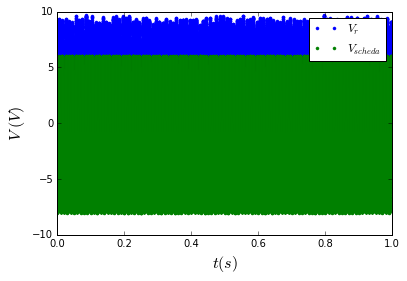

In [133]:
plot1 = plt.subplot(111)
plot1.plot(df.t, df.v_r, '.', df.t, df.v_scheda, '.')
plt.xlabel('$t (s)$', fontsize=16)
plt.ylabel('$V \; (V)$', fontsize=16)
plot1.legend(['$V_r$', '$V_{scheda}$'])

Siccome i dati sono troppo densi per essere visualizzati correttamente, effettuiamo uno zoom per analizzare la forma del segnale

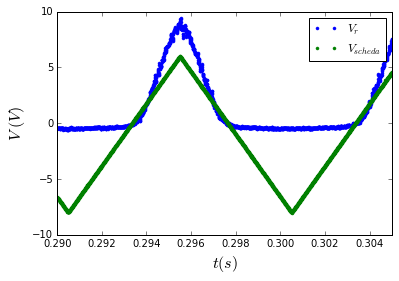

In [134]:
plot2 = plt.subplot(111)
plt.xlim(0.290,0.305)
plot2.plot(df.t, df.v_r, '.', df.t, df.v_scheda, '.')
plt.xlabel('$t (s)$', fontsize=16)
plt.ylabel('$V \; (V)$', fontsize=16)
plot2.legend(['$V_r$', '$V_{scheda}$'])

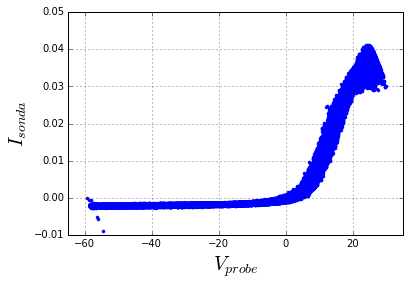

In [135]:
axs2 = plt.subplot(111)
plt.xlim(-65, 35)
plt.ylim(-0.01, 0.05)
axs2.grid(True)
axs2.plot(df.v_pr, df.i, '.')
plt.xlabel("$V_{probe}$", fontsize=20)
plt.ylabel("$I_{sonda}$", fontsize=20)

## Data binning

Decidiamo di dividere in tanti bin i nostri dati. Troviamo la soluzione ottimale. 

### Metodo 1

1. Nella zona di saturazione binniamo lungo le x con un determinato intervallo
2. Nella regione esponenziale binniamo lungo x in modo molto più stretto
3. Nell'ultima regione binniamo lungo x come in 1.

Chiamiamo `zona_1`, `zona_2`, `zona_3` le tre zone

In [137]:
def plot_data():
    # taglia i dati in un numero di bin dipendente dalle zone
    group_1 = df.groupby(pd.cut(df.v_pr, zona_1))
    group_2 = df.groupby(pd.cut(df.v_pr, zona_2))
    group_3 = df.groupby(pd.cut(df.v_pr, zona_3))
    #facciamo lo stesso per media e std
    media_1 = group_1.mean()
    std_1 = group_1.std()
    media_2 = group_2.mean()
    std_2 = group_2.std()
    media_3 = group_3.mean()
    std_3 = group_3.std()

    #plottiamo le tre zone sullo stesso grafico
    x_1    = media_1.v_pr
    y_1    = media_1.i
    xerr_1 = std_1.v_pr
    yerr_1 = std_1.i

    x_2    = media_2.v_pr
    y_2    = media_2.i
    xerr_2 = std_2.v_pr
    yerr_2 = std_2.i

    x_3    = media_3.v_pr
    y_3    = media_3.i
    xerr_3 = std_3.v_pr
    yerr_3 = std_3.i

    plot3 = plt.subplot()
    plot3.grid(True)

    plot3.errorbar(x_1, y_1, xerr=xerr_1, yerr=yerr_1)
    plot3.plot(x_1, y_1, '.')

    plot3.errorbar(x_2, y_2, xerr=xerr_2, yerr=yerr_2)
    plot3.plot(x_2, y_2, '.')

    plot3.errorbar(x_3, y_1, xerr=xerr_1, yerr=yerr_1)
    plot3.plot(x_1, y_1, '.')


In [138]:
def zone(nz1,nz2,nz3):
    zona_1 = np.linspace(-60, 0., nz1)
    zona_2 = np.linspace(0., 20., nz2)
    zona_3 = np.linspace(20., 30, nz3)
    plot_data()
interact(zone, nz1=(100,300,50),nz2=(100,300,50),nz3=(100,300,50))

ValueError: xerr must be a scalar, the same dimensions as x, or 2xN.